In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development.

In [3]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development.
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)


(1000, 2)


### Let's divide the training and test set into two partitions

In [9]:
# Your code

# Load the training data
train_data = data

# Load the test data
test_data = pd.read_csv("data/kg_test.csv", encoding='latin-1')

# Reduce the datasets for faster development
train_data = train_data.head(1000)  # Adjust as needed
test_data = test_data.head(200)  # Adjust as needed

# Print the shapes to verify the datasets
print("Training set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

# Fill NaN values if any
train_data.fillna("", inplace=True)
test_data.fillna("", inplace=True)

# The data is already divided into training and test sets
# We just need to separate features and target for each set

# For the training set
X_train = train_data['text']
y_train = train_data['label']

# For the test set
X_test = test_data['text']


Training set shape: (1000, 2)
Test set shape: (200, 1)


## Data Preprocessing

In [8]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [13]:
# Your code

import re #the regex module in the python standard library

# Function to remove inline JavaScript/CSS
def remove_inline_js_css(text):
    # Remove inline JavaScript
    text = re.sub(r'<script\b[^<]*(?:(?!<\/script>)<[^<]*)*<\/script>', '', text)
    # Remove inline CSS
    text = re.sub(r'<style\b[^<]*(?:(?!<\/style>)<[^<]*)*<\/style>', '', text)
    return text

# Function to remove HTML comments
def remove_html_comments(text):
    return re.sub(r'<!--[\s\S]*?-->', '', text)

# Function to remove remaining HTML tags
def remove_html_tags(text):
    return re.sub(r'<[^>]+>', '', text)

# Apply all three functions to the text data
X_train = X_train.apply(remove_inline_js_css).apply(remove_html_comments).apply(remove_html_tags)
X_test = X_test.apply(remove_inline_js_css).apply(remove_html_comments).apply(remove_html_tags)

print("Inline JavaScript/CSS, HTML comments, and remaining HTML tags removed.")

# Print a sample to verify the changes
print("\nSample text after removing all HTML elements:")
print(X_train.iloc[0][:500])  # Print first 500 characters of the first sample


Inline JavaScript/CSS, HTML comments, and remaining HTML tags removed.

Sample text after removing all HTML elements:
DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL I AM MIKE CHUKWU , THE MANAGER, BILLS AND EXCHANGE AT THE FOREIGN REMITTANCE DEPARTMENT OF THE ZENITH INTERNATIONAL BANK PLC. I AM WRITING THIS LETTER TO ASK FOR YOUR SUPPORT AND COOPERATION TO CARRY OUT THIS BUSINESS OPPORTUNITY IN MY DEPARTMENT. WE DISCOVERED AN ABANDONED SUM OF $15,000,000.00 (FIFTEEN MILLION UNITED STATES DOLLARS ONLY) IN AN ACCOUNT THAT BELONGS TO ONE OF OUR FOREIGN CUSTOMERS WHO DIED ALONG WITH HIS ENTIRE FAMILY OF A WIFE AND 


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters

- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [14]:
# Your code

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # Remove all special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespaces
    text = text.strip()

    return text

# Apply the cleaning function to the text data
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

print("Text cleaning completed.")

# Print a sample to verify the changes
print("\nSample text after cleaning:")
print(X_train.iloc[0][:500])  # Print first 500 characters of the first sample

Text cleaning completed.

Sample text after cleaning:
dear sir strictly private business proposal am mike chukwu the manager bills and exchange at the foreign remittance department of the zenith international bank plc am writing this letter to ask for your support and cooperation to carry out this business opportunity in my department we discovered an abandoned sum of fifteen million united states dollars only in an account that belongs to one of our foreign customers who died along with his entire family of wife and two children in november in pla


## Now let's work on removing stopwords
Remove the stopwords.

In [15]:
# Your code

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Split the text into words
    words = text.split()

    # Keep only non-stopwords
    cleaned_words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    return ' '.join(cleaned_words)

# Apply stopword removal to your already cleaned text data
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

print("Stopword removal completed.")

# Print a sample to verify the changes
print("\nSample text after stopword removal:")
print(X_train.iloc[0][:500])  # Print first 500 characters of the first sample

Stopword removal completed.

Sample text after stopword removal:
dear sir strictly private business proposal mike chukwu manager bills exchange foreign remittance department zenith international bank plc writing letter ask support cooperation carry business opportunity department discovered abandoned sum fifteen million united states dollars account belongs one foreign customers died along entire family wife two children november plane crash since heard death expecting nextofkin come put claims money heirbecause cannot release fund account unless someone appl


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [16]:
# Your code

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialise the lemmatiser
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper() # gets first letter of POS categorization
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    # Tokenise the text into words
    words = word_tokenize(text)

    # Lemmatise each word with its POS tag
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

    # Join the lemmatised words back into a string
    return ' '.join(lemmatized_words)

# Apply lemmatisation to the text data
X_train = X_train.apply(lemmatize_text)
X_test = X_test.apply(lemmatize_text)

print("Lemmatization completed.")

# Print a sample to verify the changes
print("\nSample text after lemmatization:")
print(X_train.iloc[0][:500])  # Print first 500 characters of the first sample

Lemmatization completed.

Sample text after lemmatization:
dear sir strictly private business proposal mike chukwu manager bill exchange foreign remittance department zenith international bank plc write letter ask support cooperation carry business opportunity department discover abandon sum fifteen million united state dollar account belongs one foreign customer die along entire family wife two child november plane crash since heard death expect nextofkin come put claim money heirbecause can not release fund account unless someone applies claim nextofk


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [17]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer
bow_vectorizer = CountVectorizer(max_features=1000,  # Limit to top 1000 features
                                 stop_words='english',  # Remove English stop words
                                 lowercase=True,  # Convert all text to lowercase
                                 ngram_range=(1, 2))  # Include both unigrams and bigrams

# Fit and transform the training data
X_train_bow = bow_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_bow = bow_vectorizer.transform(X_test)

print("Bag of Words vectorization completed.")
print(f"Number of features: {X_train_bow.shape[1]}")

# If you want to see the feature names (words)
feature_names = bow_vectorizer.get_feature_names_out()
print("\nSample feature names:")
print(feature_names[:10])  # Print first 10 feature names

# If you want to see the word counts for the first document
first_doc_vector = X_train_bow[0].toarray()[0]
word_count_pairs = list(zip(feature_names, first_doc_vector))
word_count_pairs = sorted(word_count_pairs, key=lambda x: x[1], reverse=True)
print("\nTop words in the first document:")
for word, count in word_count_pairs[:10]:  # Print top 10 words
    if count > 0:
        print(f"{word}: {count}")

Bag of Words vectorization completed.
Number of features: 1000

Sample feature names:
['abacha' 'abandon' 'abandon sum' 'abidjan' 'able' 'abroad' 'ac' 'accept'
 'acceptance' 'access']

Top words in the first document:
fund: 6
bank: 5
department: 5
account: 4
business: 4
claim: 4
foreign: 4
come: 3
agree: 2
country: 2


## Extra features

In [23]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

X_train = X_train.to_frame(name='text')
X_test = X_test.to_frame(name='text')

text_column_name = 'text'

X_train['money_mark'] = X_train[text_column_name].str.contains(money_simbol_list)*1
X_train['suspicious_words'] = X_train[text_column_name].str.contains(suspicious_words)*1
X_train['text_len'] = X_train[text_column_name].apply(lambda x: len(x))

X_test['money_mark'] = X_test[text_column_name].str.contains(money_simbol_list)*1
X_test['suspicious_words'] = X_test[text_column_name].str.contains(suspicious_words)*1
X_test['text_len'] = X_test[text_column_name].apply(lambda x: len(x))

X_train.head()

,text,money_mark,suspicious_words,text_len
0,dear sir strictly private business proposal mi...,1,1,1471
1,,1,0,0
2,noracheryl email dozen memo haiti weekend plea...,1,0,108
3,dear sirfmadamc know proposal might surprise e...,1,1,1353
4,fyi,1,0,3


## How would work the Bag of Words with Count Vectorizer concept?

In [24]:
# Your code

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Create CountVectorizer
bow_vectorizer = CountVectorizer(max_features=1000,  # Limit to top 1000 features
                                 stop_words='english',  # Remove English stop words
                                 lowercase=True,  # Convert all text to lowercase
                                 ngram_range=(1, 2))  # Include both unigrams and bigrams

# Fit and transform the training data
X_train_bow = bow_vectorizer.fit_transform(X_train)

# Get feature names (words)
feature_names = bow_vectorizer.get_feature_names_out()

# Create a DataFrame for the first few documents
num_docs_to_show = 5
bow_df = pd.DataFrame(X_train_bow[:num_docs_to_show].toarray(), columns=feature_names)

print("Bag of Words representation (first 5 documents, top 10 features):")
print(bow_df.iloc[:, :10])  # Show only first 10 columns for brevity

# Print vocabulary size
print(f"\nVocabulary size: {len(bow_vectorizer.vocabulary_)}")

# Print top 10 most common words
word_freq = X_train_bow.sum(axis=0).A1
word_freq_df = pd.DataFrame({'word': feature_names, 'freq': word_freq})
word_freq_df = word_freq_df.sort_values('freq', ascending=False).reset_index(drop=True)

print("\nTop 10 most common words:")
print(word_freq_df.head(10))

# Example of how to get BoW representation for a specific document
doc_index = 0  # Change this to look at different documents
doc_bow = X_train_bow[doc_index].toarray()[0]
doc_words = [word for word, count in zip(feature_names, doc_bow) if count > 0]

print(f"\nWords in document {doc_index}:")
print(doc_words[:20])  # Print first 20 words

Bag of Words representation (first 5 documents, top 10 features):
   money_mark  suspicious_words  text  text_len
0           0                 0     1         0
1           1                 0     0         0
2           0                 1     0         0
3           0                 0     0         1

Vocabulary size: 4

Top 10 most common words:
               word  freq
0        money_mark     1
1  suspicious_words     1
2              text     1
3          text_len     1

Words in document 0:
['text']


## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [35]:
# Your code

from sklearn.feature_extraction.text import TfidfVectorizer

# Load the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000,  # Limit to top 1000 features
                                   stop_words='english',  # Remove English stop words
                                   lowercase=True,  # Convert all text to lowercase
                                   ngram_range=(1, 2))  # Include both unigrams and bigrams

# Vectorize all datasets
# Fit on training data, transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean['text'])  # Access the 'text' column
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the vectorized datasets
print("Shape of the vectorized training dataset:", X_train_tfidf.shape)
print("Shape of the vectorized test dataset:", X_test_tfidf.shape)

# Optional: Print some additional information
print("\nNumber of features:", len(tfidf_vectorizer.get_feature_names_out()))

# Print top 10 features (words) by their IDF score
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_scores = tfidf_vectorizer.idf_
feature_idf_pairs = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])

print("\nTop 10 features by IDF score (rare words):")
for feature, idf in feature_idf_pairs[:10]:
    print(f"{feature}: {idf}")

print("\nBottom 10 features by IDF score (common words):")
for feature, idf in feature_idf_pairs[-10:]:
    print(f"{feature}: {idf}")

Shape of the vectorized training dataset: (1000, 1000)
Shape of the vectorized test dataset: (4, 1000)

Number of features: 1000

Top 10 features by IDF score (rare words):
money: 2.238873856334701
fund: 2.288353913598071
business: 2.348073148299693
account: 2.383301840183437
contact: 2.3953260331502384
million: 2.3993664426872434
make: 2.436484105643746
country: 2.4706754703920253
bank: 2.475032775760981
state: 2.4882197800429346

Bottom 10 features by IDF score (common words):
hvnt hrd: 7.215607598755275
ind: 7.215607598755275
ind men: 7.215607598755275
men worn: 7.215607598755275
rep dem: 7.215607598755275
unfavorable havent: 7.215607598755275
unfavorable hvnt: 7.215607598755275
wht: 7.215607598755275
worn: 7.215607598755275
worn wht: 7.215607598755275


In [36]:
# Before training, check the shape of your data
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train_tfidf: (1000, 1000)
Shape of y_train: (1000,)


## And the Train a Classifier?

In [37]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Check the content of X_train
print("First few entries of X_train:")
print(X_train.head())
print("\nData type of X_train:", type(X_train))

# Check for empty or NaN values
print("\nNumber of empty or NaN values in X_train:", X_train.isna().sum())

# Check for empty strings
print("\nNumber of empty strings in X_train:", (X_train == '').sum())

# Remove any empty or NaN values
X_train_clean = X_train.dropna().replace('', np.nan).dropna()
y_train_clean = y_train[X_train_clean.index]

print("\nShape of cleaned X_train:", X_train_clean.shape)
print("Shape of cleaned y_train:", y_train_clean.shape)

# Print some statistics about the text length
# Assuming 'text' is the column containing the text data
text_lengths = X_train_clean['text'].str.len()  # Access the 'text' column
print("\nText length statistics:")
print(text_lengths.describe())

# Print the first few cleaned entries
print("\nFirst few cleaned entries:")
print(X_train_clean.head())

# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean['text']) # Access the 'text' column

# Verify the shape of the TF-IDF matrix
print("\nShape of X_train_tfidf:", X_train_tfidf.shape)

# Print the vocabulary size
print("Vocabulary size:", len(tfidf_vectorizer.get_feature_names_out()))

# If the shape is still incorrect, let's print the unique words in the corpus
if X_train_tfidf.shape[1] < 5:
    unique_words = set(' '.join(X_train_clean['text']).split()) # Access the 'text' column
    print("\nUnique words in the corpus:", unique_words)
    print("Number of unique words:", len(unique_words))

# Don't proceed with classifier training if the data is not correctly vectorized

First few entries of X_train:
                                                text  money_mark  \
0  dear sir strictly private business proposal mi...           1   
1                                                              1   
2  noracheryl email dozen memo haiti weekend plea...           1   
3  dear sirfmadamc know proposal might surprise e...           1   
4                                                fyi           1   

   suspicious_words  text_len  
0                 1      1471  
1                 0         0  
2                 0       108  
3                 1      1353  
4                 0         3  

Data type of X_train: <class 'pandas.core.frame.DataFrame'>

Number of empty or NaN values in X_train: text                0
money_mark          0
suspicious_words    0
text_len            0
dtype: int64

Number of empty strings in X_train: text                16
money_mark           0
suspicious_words     0
text_len             0
dtype: int64

Shape of cleaned X_tr

In [40]:
# Your code
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Check the content of X_train
print("First few entries of X_train:")
print(X_train.head())
print("\nData type of X_train:", type(X_train))

# Check for empty or NaN values
print("\nNumber of empty or NaN values in X_train:", X_train.isna().sum())

# Remove any empty or NaN values
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]

print("\nShape of cleaned X_train:", X_train_clean.shape)
print("Shape of cleaned y_train:", y_train_clean.shape)

# Convert to list if it's a pandas Series
# Ensure you are accessing the correct column for text data (e.g., 'text')
if isinstance(X_train_clean, pd.Series):
    X_train_clean = X_train_clean.tolist()
elif isinstance(X_train_clean, pd.DataFrame):
    X_train_clean = X_train_clean['text'].tolist() # Access the 'text' column

# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)

# Verify the shape of the TF-IDF matrix
print("\nShape of X_train_tfidf:", X_train_tfidf.shape)

# Initialize and train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train_clean)

# Transform the test data
# Ensure you are accessing the correct column for text data (e.g., 'text')
if isinstance(X_test, pd.Series):
    X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())
elif isinstance(X_test, pd.DataFrame):
    X_test_tfidf = tfidf_vectorizer.transform(X_test['text'].tolist()) # Access the 'text' column

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Print some example predictions
n_samples = 5
print(f"\nExample predictions for {n_samples} samples:")
for i in range(n_samples):
    predicted_label = y_pred[i]
    text = X_test.iloc[i][:100]  # First 100 characters of the text
    print(f"Predicted: {predicted_label}")
    print(f"Text: {text}...")
    print()

# Save the predictions
submission = pd.DataFrame({'id': X_test.index, 'predicted_label': y_pred})
submission.to_csv('naive_bayes_predictions.csv', index=False)
print("Predictions saved to 'naive_bayes_predictions.csv'")

First few entries of X_train:
                                                text  money_mark  \
0  dear sir strictly private business proposal mi...           1   
1                                                              1   
2  noracheryl email dozen memo haiti weekend plea...           1   
3  dear sirfmadamc know proposal might surprise e...           1   
4                                                fyi           1   

   suspicious_words  text_len  
0                 1      1471  
1                 0         0  
2                 0       108  
3                 1      1353  
4                 0         3  

Data type of X_train: <class 'pandas.core.frame.DataFrame'>

Number of empty or NaN values in X_train: text                0
money_mark          0
suspicious_words    0
text_len            0
dtype: int64

Shape of cleaned X_train: (1000, 4)
Shape of cleaned y_train: (1000,)

Shape of X_train_tfidf: (1000, 1000)

Example predictions for 5 samples:
Predicted: 1
Text: 

Cross-validation scores: [0.945 0.95  0.955 0.97  0.93 ]
Mean CV score: 0.9500
Standard deviation of CV scores: 0.0130

Mean prediction confidence: 0.8764
Median prediction confidence: 0.9470


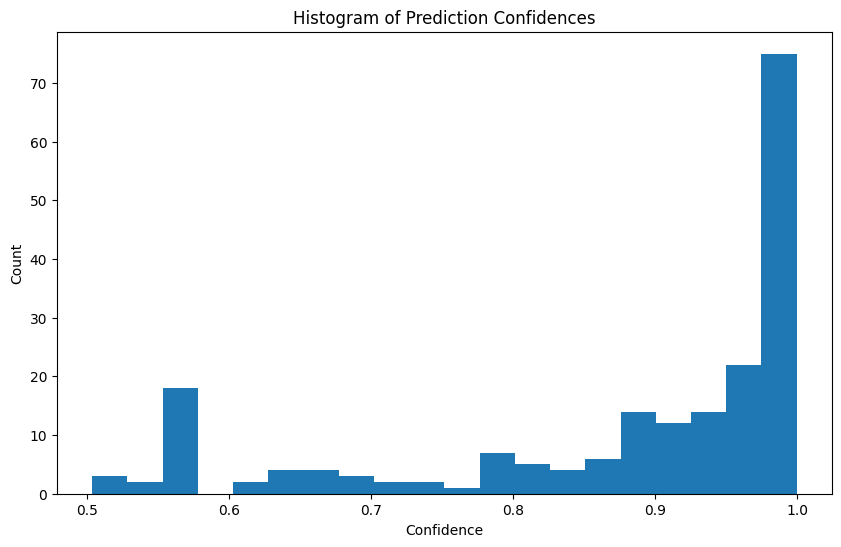

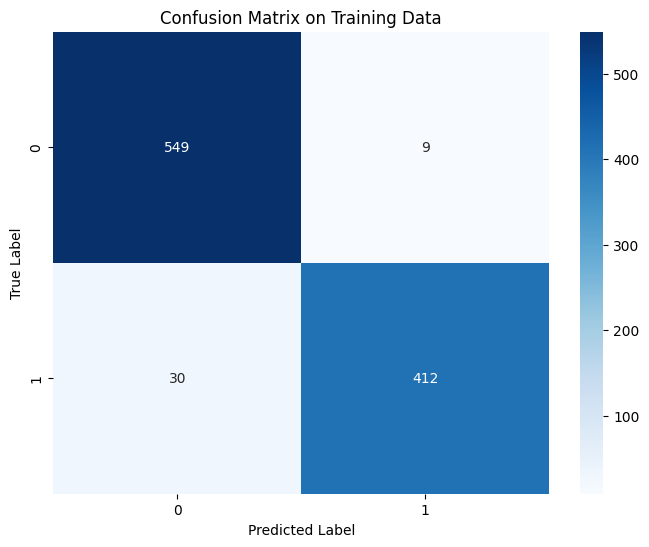


Prediction statistics:
Number of samples: 200
Number of unique predicted labels: 2

Proportion of each predicted label:
0    0.535
1    0.465
Name: proportion, dtype: float64

Top 10 features for class 0:
fyi: 0.0203
ok: 0.0085
yes: 0.0071
work: 0.0066
tomorrow: 0.0066
talk: 0.0066
pls: 0.0063
pm: 0.0058
cheryl: 0.0054
today: 0.0053

Top 10 features for class 1:
money: 0.0091
bank: 0.0086
account: 0.0084
fund: 0.0079
transfer: 0.0062
business: 0.0054
contact: 0.0052
transaction: 0.0051
country: 0.0049
company: 0.0048

Predictions saved to 'naive_bayes_predictions.csv'


In [42]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Perform cross-validation on the training set
cv_scores = cross_val_score(nb_classifier, X_train_tfidf, y_train_clean, cv=5)

print("Cross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV scores: {cv_scores.std():.4f}")

# Get class probabilities for the test set
class_probs = nb_classifier.predict_proba(X_test_tfidf)

# Calculate prediction confidence
confidence = np.max(class_probs, axis=1)

print(f"\nMean prediction confidence: {confidence.mean():.4f}")
print(f"Median prediction confidence: {np.median(confidence):.4f}")

# Plot histogram of prediction confidences
plt.figure(figsize=(10, 6))
plt.hist(confidence, bins=20)
plt.title('Histogram of Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.show()

# Print confusion matrix on training data
y_train_pred = nb_classifier.predict(X_train_tfidf)
cm = confusion_matrix(y_train_clean, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print some statistics about the predictions
print("\nPrediction statistics:")
print(f"Number of samples: {len(y_pred)}")
print(f"Number of unique predicted labels: {len(np.unique(y_pred))}")
value_counts = pd.Series(y_pred).value_counts(normalize=True)
print("\nProportion of each predicted label:")
print(value_counts)

# Print top features for each class
feature_names = tfidf_vectorizer.get_feature_names_out()
for i, class_label in enumerate(nb_classifier.classes_):
    top_features = np.argsort(nb_classifier.feature_log_prob_[i])[-10:]
    print(f"\nTop 10 features for class {class_label}:")
    for idx in top_features[::-1]:
        print(f"{feature_names[idx]}: {np.exp(nb_classifier.feature_log_prob_[i, idx]):.4f}")

# Save the predictions
submission = pd.DataFrame({'id': X_test.index, 'predicted_label': y_pred})
submission.to_csv('naive_bayes_predictions.csv', index=False)
print("\nPredictions saved to 'naive_bayes_predictions.csv'")

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).